### Program Structure and Execution

- There are no "special" statements, and every statement can be placed anywhere in a program.
- When loading source files, the interpreter **always executes every statement in order until there are no more statements to execute**. This execution model applies both to files you simply run as the main program and to library files that are loaded via import.

### Loops and Iteration

- `range()` in `Python3` is an iterator.

- In the statement `for i in s`, the variable `i` is known as the **iteration variable**. 
    - On each iteration of the loop, it receives a new value from `s`. The **scope** of the iteration variable is not private to the for statement. If a previously defined variable has the same name, that value will be overwritten. 
    - Moreover, the iteration variable retains the **last value after the loop has completed**.
    
- The `break` and `continue` statements apply only to the innermost loop being executed. If it’s necessary to break out of a deeply nested loop structure, you can use an exception. Python doesn’t provide a `goto` statement.

- The `else` clause of a loop executes only if the loop runs to completion. This either occurs immediately (if the loop wouldn’t execute at all) or after the last iteration. The primary use case for the looping else clause is in code that iterates over data but which needs to set or check some kind of flag or condition if the loop breaks prematurely; Item 12 of [< Effective Python >](https://www.evernote.com/shard/s191/nl/21353936/80774c17-012b-c7d8-e425-a9b3eb0d55f3?title=Effective%20Python) does not approve of this usage though. 

### Exceptions

- Exceptions are the way that python handle control flows; see example codes below.

- If the `raise` statement is used by itself, the last exception generated is raised again (although this works only while handling a previously raised exception).

- To catch multiple exceptions in one `except`, you will need to specify a `tuple`; see the 3rd mistake in [this post](https://www.evernote.com/shard/s191/nl/21353936/06c8859d-90c6-4688-a5a9-ef37f71e38f2?title=The%2010%20Most%20Common%20Mistakes%20That%20Python%20Developers%20Make%20%7C%20Toptal).

In [ ]:
import sys

# User defined exception. Very often, exceptions are derived from Exception.
class BloombergError(Exception):
    pass

li = []

try:
    raise BloombergError('server down')
    li[0] = 67
    10 / 0
except BloombergError: # All exceptions are classes, but there is no parantheses in the class name after except.
    exc_type, exc_obj, exc_tb = sys.exc_info() # Exception type, obj and traceback
    sys.stderr.write( str(exc_obj) + '\n' ) # Quite often in exception handling, the return type is an object, even though superficially it should be strings.
    raise Exception( 'Some more useful information for the outer layer of code' ) # re-raise the exception
    sys.exit(3)
except (ZeroDivisionError, IndexError): # Specify a tuple to share common handling between different errors - it has to be a tuple!!
    exc_type, exc_obj, exc_tb = sys.exc_info()
    sys.exit(1)
except Exception as e: # value provides object reference to the exception as well
    
    exc_type, exc_obj, exc_tb = sys.exc_info()
    sys.stderr.write( str(exc_type) + '\n' )
    sys.stderr.write( f'unexpected exception: {e}\n')
    sys.exit(1)
else: # The else block helps minimize the amount of code in try blocks and visually distinguish the success case from the try/except blocks
    print('No exceptions raised')
finally: # suitable for common cleanup, regardless of whether exceptions occur
    print('always done')

### Built-in Exceptions

- All the exceptions in a particular group can be caught by specifying the group name in an `except` clause - should be polymophism.

- At the top of the exception hierarchy, the exceptions are grouped according to whether or not the exceptions are related to program exit. For example, the `SystemExit` and `KeyboardInterrupt` exceptions are not grouped under `Exception`.

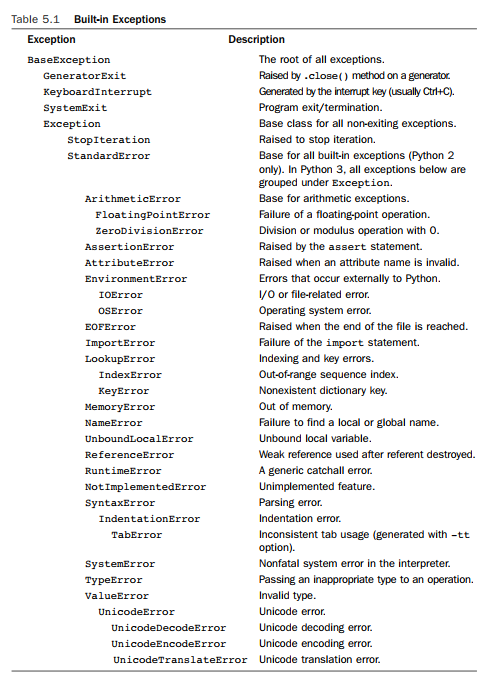

### Defining New Exceptions

- To create a new exception, create a new class definition that inherits from `Exception`.

- When raising an exception, the optional values supplied with the `raise` statement are used as the arguments to the exception’s class constructor. **Most of the time, this is simply a string indicating some kind of error message**. However, user-defined exceptions can be written to take one or more exception values; an example can be found on Page 88 of [< Python Essential References >](https://www.evernote.com/shard/s191/nl/21353936/3a76bfd7-5b40-de76-dc58-c1805f99d416?title=Python%20Essential%20References). When you create a custom exception class that redefines `__init__()`, it is important to **assign a tuple containing the arguments** to `__init__()` to the **attribute** `self.args`: this attribute is used when pricing exception traceback messages.

### Notes on `try`-`except`-`else`-`finally`

- The `try`-`except` statement has an optional `else` clause, which, when present, must follow all `except` clauses. It is useful for code that must be executed if the `try` **clause does not raise an exception**. The use of the `else` clause is better than adding additional code to the `try` clause because it avoids accidentally catching an exception that wasn’t explicitly handled by the `except` statement: if instead it was in the `else` block, it will propagate up. 

- If a `finally` clause is present, the `finally` clause will execute **as the last task before the try statement completes**. The `finally` clause **runs whether or not the try statement produces an exception**. The following points discuss more complex cases when an exception occurs:

    - If an exception occurs during execution of the `try` clause, the exception may be handled by an `except` clause. If the exception is not handled by an `except` clause, **the exception is re-raised after** the `finally` clause has been executed.

    - An exception could occur during execution of an `except` or `else` clause. Again, **the exception is re-raised after the finally clause has been executed**.

    - If the `finally` clause executes a `break`, `continue` or `return` statement, **exceptions are not re-raised**.

    - If the try statement reaches a `break`, `continue` or `return` statement, the `finally` clause will **execute just prior to** the `break`, `continue` or `return` statement’s execution.

    - If a `finally` clause includes a return statement, the returned value will be the one from the `finally` clause’s return statement, not the value from the `try` clause’s return statement.

  Building on the first point above, when exception is raised in handler, original exception can get lost. The right way is to perform a cleanup in a `finally` block; compare the two versions of `myfunc` below (The below also touches on two good practices concerning exceptions: <font color='red'> **tracebacks** </font> and <font color='red'> **logging** </font>). More examples can be found in Item 13 of [< Effective Python >](https://www.evernote.com/shard/s191/nl/21353936/80774c17-012b-c7d8-e425-a9b3eb0d55f3?title=Effective%20Python).

In [ ]:
import traceback
import logging

def doit():
    # some nested function encounters a problem
    raise RuntimeError('original error')
    
def myfunc_v1():
    try:
        doit()
    except:
        # if errorCorrection() fails
        # it will mask out the original exception
        errorCorrection()
        
def myfunc_v2():
    try:
        doit()
    except:
        try: # re-raise the original error first
            raise
    finally:
        # try handling the problem locally
        try:
            errorCorrection()
        except: 
            traceback.print_exc() 
            # exactly mimics the behavior of the python interpreter when it prints a stack trace
            # print_exc takes two optional variables: limit and file - prints limit entries in a stack tracce to a file.
            # if omitted, the full trace is printed to the console.
            logging.error("Some error occurs")

### Context Managers and the `with` Statement

- Proper management of system resources such as files, locks, and connections is often a tricky problem when combined with exceptions. For example, a raised exception can cause control flow to bypass statements responsible for releasing critical resources such as a lock.

- The with statement allows a series of statements to execute inside a runtime context that is controlled by an object that serves as a context manager.

- The `contextlib` module allows custom context managers to be more easily implemented by placing a wrapper around a generator function; see the second code block below.

In [ ]:
#with open('hello.txt') as f: # f is the handle and it is optional
#    for line in f:
#        print line

class Ctx_Mgr(object):
    def __enter__(self):
        print('enter')
        return 42
    
    def __exit__(self, exc_type, exc_obj, exc_tb): # The last three variables are for exceptions handling - if there is no exceptions, exc variables will be None.
        if exc_type is not None:
            print('exception')
            return True # This is the line needed for exceptions to be truly handled - by default, this exit function does not return True
        print('exit')
        
with Ctx_Mgr as val:
    # The protocol of the context manager...
    # (1) Obj = Ctx_Mgr(): similar in open(file), which returns an object
    # (2) obj.__enter__() and is given to the variable after 'as' (if any) and it is a global variable!
    # (3) execute the body, as below
    
    # 10 / 0 if there is an exception in the body, control is haneded over to exit directly and all three exc variables will be non-trivially populated.
    print(42)
    print('in body')
    
    # (4) obj.__exit__()


In [ ]:
"""Class solution"""

import pickle

class AutoSave(object):
    def __init__(self, d):
        self.d = d
    def __enter__(self):
        print('enter')
        self.fo = open('data.out', 'w')
        return self.d
    def __exit__(self, exc_type, exc_obj, exc_tb):
        if exc_type is not None:
            print('Exception!')
            return True
        
        pickle.dump(self.d, self.fo)
        self.fo.close()
        print('exit')
        
d = {}
with AutoSave(d) as h:
    d['usa'] = 1
    d['uk'] = 44
    # 10/ 0
    
for key, value in h.items(): #Again h is a global variable!
    print("{}:{}".format(key, value))
    
"""Function/decorator solution"""

# But to understand this solution you need to understand the class solution first.

import pickle
from contextlib import contextmanager

@contextmanager
def autosave(d):
    # No __init__ method needed
    
    # First the __enter__ part
    print('enter')
    fo = open('data.out', 'w')
    
    try:
        yield # yielding control to the decorator
    except Exception:
        print('Exception!')
        
    # The the __exit__ part
    pickle.dump(d, fo)
    fo.close()
    print('exit')
    
    

### Assertion and `__debug__`

- The `assert` statement should not be used for code that must be executed to make the program correct because it won’t be executed if Python is run in optimized mode (specified with the `-O` option to the interpreter).  Instead, `assert` statements are used to check things that should always be true; if one is violated, it represents a bug in the program, not an error by the user.

- In addition to `assert`, Python provides the built-in read-only variable `__debug__`, which is set to `True` unless the interpreter is running in optimized mode (specified with the `-O` option).
    - If `Python` is running in its normal mode, the statements under the if `__debug__` statement are just inlined into the program without the `if` statement itself. In optimized mode, the `if __debug__` statement and all associated statements are completely removed from the program.
    - As such,  in debug mode, you can liberally instrument your code with assertions and debug checks to verify correct operation. In optimized mode, all of these extra checks get stripped, resulting in no extra performance penalty.

## References
- [< Python Essential References >](https://www.evernote.com/shard/s191/nl/21353936/3a76bfd7-5b40-de76-dc58-c1805f99d416?title=Python%20Essential%20References), Chapter 5.
- Bloomberg training in exception handling
- Bloomberg training in context management\